In [23]:
import random
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
import nltk
import time
import ftfy
from collections import Counter
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

# Data Preprocessing

In [24]:
# read the original dataset
original = pd.read_csv("/Users/haox/Desktop/fake_job_postings.csv")
original.shape
original.isnull().sum()/len(original)

job_id                 0.000000
title                  0.000000
location               0.019351
department             0.645805
salary_range           0.839597
company_profile        0.185011
description            0.000056
requirements           0.150727
benefits               0.403244
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
employment_type        0.194128
required_experience    0.394295
required_education     0.453300
industry               0.274217
function               0.361018
fraudulent             0.000000
dtype: float64

Before we start to predict the fake job posting by classificationn model, we can drop the columns that does not deeply correlate with the prediction such as "job_id", "title", "location". Besides, since the dataset has a lot of missing or null value, we have to delete the columns that has a lot of missing value, such as "department"(64.58% null), "salary_range"(83.96% null), "benefits" (40.32% null), "required_education (45.33% null)" etc.

As a result, the remaining dataset consists "telecommuting", "has_company_logo", "has_questionns", "description", "fradulent". The column "description" has the detailed description of the job posting which would be the most helpful column for the prediction.

In [25]:
#extract the useful columns from the dataset.
data = original.loc[:, ["telecommuting","has_company_logo","has_questions","description","fraudulent"]]
# set the orders of the columns
columns_order = ["telecommuting","has_company_logo","has_questions","description","fraudulent"]
data = data[columns_order]

# in the currrent dataset, there is still one row that has null value indescription, so we have to drop it.
data = data.dropna()

In [26]:
print("fake job posting: ", data.loc[data["fraudulent"]==1, :].shape[0])
print("real job posting: ", data.loc[data["fraudulent"]==0, :].shape[0])

fake job posting:  865
real job posting:  17014


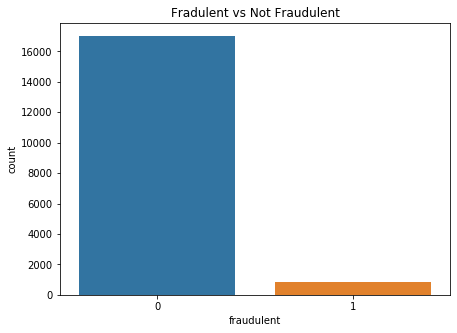

In [27]:
plt.figure(figsize = (7,5))
sns.countplot(x = data.fraudulent, data = data)
plt.title('Fradulent vs Not Fraudulent')
plt.show()

*  Fake job posting: 865
*  Real job posting: 17014
*  From the comparison of the fake and real job posting in this dataset, we know that there is a serious imbalance in the dataset. In order to balance the dataset for better utilization, we extract all the fake job posting and then random sample 1000 real job posting.

In [28]:
# set the random seed
random.seed(42)
# extract 1000 rows from the dataset where fraudulent equals to 0 for future model training
data_fraudulent_0_idx = random.choices(data.loc[data["fraudulent"]==0].index, k=1000)
data_fraudulent_0 = data.loc[data_fraudulent_0_idx, :]

# extract all the rows where fraudulent is 1
data_fraudulent_1 = data.loc[data["fraudulent"]==1, :]

# concatenate the dataframe above into a new dataframe
data = pd.concat([data_fraudulent_0, data_fraudulent_1], axis=0)
#Use shuffle in the sklearn.util to randomly reorder the rows in the new dataframe (we set the random seed as 42).
data = shuffle(data, random_state=42)

# Preprocess the text of "description" column

In this part, we use the module nltk to tokenize the "description" column to extract features to build NLP model 

In [29]:
# 1. preprocess the text of "description"

#in order to analyze the text in description, we first have to deal with the space, line feeds and url.
# def preprocess(text):

#     multispace_re = re.compile(r"\s{2,}")
#     newline_re = re.compile(r"\n+")
#     url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")
#     # emoji_re = re.compile("([\U00010000-\U0010ffff]|[\uD800-\uDBFF][\uDC00-\uDFFF])")

#     preprocessed_text = multispace_re.sub("",text)
#     preprocessed_text = newline_re.sub("",preprocessed_text)
#     preprocessed_text = url_re.sub("url", preprocessed_text)
#     preprocessed_text = ftfy.fix_text(preprocessed_text)
#     return preprocessed_text


# 2. use the word tokenize tool in nltk to split the words in the text of description
def nltk_word_tokenize(text, advanced_tokenize=True):
    if advanced_tokenize:
        advanced_text_tokenize = nltk.tokenize.TweetTokenizer()
        return advanced_text_tokenize.tokenize(text)
    else:
        return nltk.word_tokenize(text)


# 3. create a class to generate a document to restore all the words that were splitted in the 'description' column by using nltk module
class Document():
    def __init__(self):
        # create a token list to store all the words after split
        self.tokens_list = []
        # initialize an int to count how many words after split
        self.num_tokens = 0
        # store the processed words
        self.text = ""
        

    def extract_features_from_text(self,text):

        # preprocessed_text = preprocess(text)
        # self.text += preprocessed_text
        self.text += text

        # extract words
        tokens = nltk_word_tokenize(text)
        self.tokens_list.extend(tokens)
        self.num_tokens += len(tokens)
 

    def extract_features_from_texts(self, texts):
        for text in texts:
            self.extract_features_from_text(text)




# Build the model

* In this part, in order to build the classification model, we first have to vectorize the data
* Then we use three algorithm to train the model
    * Logistic Regression
    * SVM Machine
    * Neural Network

In [33]:
# Use the skip-gram model on gensim.models.word2vec to featurize the words and build the training model for the "description" column
# The reason we choose the skip-gram model instead of CBOW model is because skip-gram is more sensitive to the low frequency words because of the nature of dense vectors.
# reference source
# https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/
# https://radimrehurek.com/gensim/models/word2vec.html
# https://blog.csdn.net/zl_best/article/details/53433072?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-5&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-5
from gensim.models import word2vec
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier


class Fake_job_cls_models():
    def __init__(self,data_df):
        self.data_df = data_df.copy()
        # put the other columns except "description" into a new dataframe and turn the dataframe into a Numpy array for future use
        self.data_other = np.array( self.data_df.loc[:,["telecommuting","has_company_logo","has_questions"]] )
        
        # make a new dataframe that only store the "description" column so that we can do word embedding
        self.data_description_df = self.data_df["description"].to_frame()
        # description_sen_tokens stores all the features of descrption after tokenized
        self.description_sen_tokens = None
        # initialize a variable to store the trained Skip-gram model in order to extra a particular feature vector
        self.word2vec_model = self.description_word2vec_model(self.data_description_df)
        
        # store the density vector that were transferred from "description"
        self.data_description_vectors = self.description_vectorized_data_creation(self.data_description_df, mean_vector = True)
        
        #stack horizontally the dense vector and data.other which are already in numpy array 
        self.X = np.hstack( (self.data_other, self.data_description_vectors) )
        
        # turn the fradulent column into numpy array
        self.Y = np.array( self.data_df["fraudulent"] )

    # from the last part, we build a class to tokenize all the text descriotion. 
    # Create Document object to store the tokenized data.
    def corpus_creation(self, data_description_df):
        for row in range(data_description_df.shape[0]):
            doc = Document()
            doc.extract_features_from_text(data_description_df.iloc[row,0])
            yield doc
    
    
    
    def description_word2vec_model(self, data_description_df):
        # create a corpus list to store all the tokenized documents object in description
        corpus = []
        corpus.extend( self.corpus_creation(data_description_df) )
        # description_sen_tokens stores all the features of descrption after tokenized
        self.description_sen_tokens = [doc.tokens_list for doc in corpus]

        # The model is based on the Skip-gram model in word2vec (set sg = 1). We use this model to vectorize the all the features
        # of the tokenized words into word embedding with a size of 300.
        # The reason we use Skip-gram instead of CBOW is because for a detailed descrpition like our data, Skip-gram will better capture the semantic between words
        # We use negative sampling (hs = 0) to improve the performance.
        # we set negative = 10 which means for each of every words we will have 10 negative sample
        # by capturing these negative samples, we would reduce the size of matrix significantly
        word2vec_model = word2vec.Word2Vec(sentences=self.description_sen_tokens, size=300, window=9, min_count=1, sg=1, hs=0,
                                           negative=10, seed=42, iter=5, workers=4)
        return word2vec_model
    
    

    # The reason we use word embedding is because the vector could represent the density of the tokenized word in the text.
    # We use the mean (mean_vector = true) of the word embedding to represent the density of the pattern.
    # comparing to the "bag of words" method which would give us sparse feature pattern, we could get a dense vector
    # where most of the value is non-zero.
    # We could finish the NLP step by vectorizing the natural languae using after it finish all the iteration and completely insert all the density values
    def description_vectorized_data_creation(self, data_description_df, mean_vector = True):
        
        # initialize an empty numpy arrary to store the density of the vector, the column the number of tokenized word and the row is the size of the word embedding
        data_description_vectors = np.zeros( (len(self.description_sen_tokens), 300) )

        for num in range(len(self.description_sen_tokens)):
            each_description_tokens = self.description_sen_tokens[num]
            each_description_vectors = None
            
            # if the length of the description token is not zero
            if len(each_description_tokens) != 0:
                
                if mean_vector:
                    each_description_vectors = np.vstack((self.word2vec_model.wv[token] for token in each_description_tokens))
                    # get the density by getting the mean value of the 300-size word embedding vector
                    each_description_vectors = np.mean(each_description_vectors, axis=0)

                else:
                    each_description_vectors = np.vstack((self.word2vec_model.wv[token] for token in each_description_tokens))
                    # if the mean_vector is false, get the density by getting the sum value of the word embedding
                    each_description_vectors = np.sum(each_description_vectors, axis=0)

                # after each of the iteration, update the data description vector by inserting the density of the word vector 
                data_description_vectors[num] = each_description_vectors
                
            else:
            # if the length of the description token is zero, print the number of them
                print("0 num:",num)
                continue
        return data_description_vectors

    
    
    # we build this method to see the important measure of evaluating the following classification model, such as the mean, standard deviation, min and max of
    # accuracy, precision, recall，and F1
    def print_cv_scores_summary(self, cv_scores):
        def cv_score_summary(name,scores):
            print("{}:  mean = {:.2f}%,  sd = {:.2f}%,  min = {:.2f}%,  max = {:.2f}%".format(name, scores.mean() * 100,
                                                                                        scores.std() * 100,
                                                                                        scores.min() * 100,
                                                                                        scores.max() * 100))

        cv_score_summary("Accuracy", cv_scores['test_accuracy'])
        cv_score_summary("Precision", cv_scores['test_precision_weighted'])
        cv_score_summary("Recall", cv_scores['test_recall_weighted'])
        cv_score_summary("F1", cv_scores['test_f1_weighted'])
        
    
    # Here we use logistic regression. 
    # Since the essense of logistic regression is a linear regression with the sigmoid function which will also show the direction of association,
    # which is suitable for classification model.
    # We generate a 10 time cross validation and output the important measures that we mentioned above to evaluate the performance
    def Logis_Regression(self):
        time_start = time.time()
        
        logis_reg = LogisticRegression(penalty='l1',solver="liblinear",max_iter=300)
        logis_reg_cv_scores = cross_validate(logis_reg, self.X, self.Y, cv=StratifiedKFold(n_splits=10,random_state=0), return_train_score=False,
                                       scoring=["accuracy","precision_weighted","recall_weighted","f1_weighted"])
        
        time_end = time.time()
        print("model run time: ", time_end - time_start, "seconds")
        
        print("After 10 times of cross validation of logistic regression, the results of measures are: ")
        self.print_cv_scores_summary(logis_reg_cv_scores)
    
    
    
    # SVM
    def SVM(self):
        time_start = time.time()
        
        svm = NuSVC()
        
        # 10 times cross validation
        svm_cv_scores = cross_validate(svm, self.X, self.Y, cv=StratifiedKFold(n_splits=10,random_state=0), return_train_score=False,
                                       scoring=["accuracy","precision_weighted","recall_weighted","f1_weighted"])
        
        time_end = time.time()
        print("model run time: ", time_end - time_start, "seconds")
        
        print("After 10 times of cross validation of SVM, the results of measures are: ")
        self.print_cv_scores_summary(svm_cv_scores)
    
    
    
    # FNN
    def FNN(self):
        time_start = time.time()
        
        # Build the neural network, the first hidder layer is 30, the second is 20
        nn = MLPClassifier(hidden_layer_sizes=(30,20), activation='relu', learning_rate="adaptive", max_iter=500,
                          warm_start=True)
        
        # 10 times cross validation
        nn_cv_scores = cross_validate(nn, self.X, self.Y, cv=StratifiedKFold(n_splits=10,random_state=0), return_train_score=False,
                                       scoring=["accuracy","precision_weighted","recall_weighted","f1_weighted"])
        
        time_end = time.time()
        print("model run time: ", time_end - time_start, "seconds")
        
        print("After 10 times of cross validation of FNN, the results of measures are:: ")
        self.print_cv_scores_summary(nn_cv_scores)

In [34]:
fake_job_cls_models = Fake_job_cls_models(data)

0 num: 225


In [51]:
print("The words or phrase that most similar to 'experience' is:")
print(fake_job_cls_models.word2vec_model.wv.most_similar("experience"))
print("="*100)
print("The words or phrase that most similar to 'part-time' is:")
print(fake_job_cls_models.word2vec_model.wv.most_similar("part-time"))

The words or phrase that most similar to 'experience' is:
[('years', 0.7516058683395386), ('programming', 0.6670236587524414), ('preferably', 0.6629071235656738), ('Minimum', 0.6620178818702698), ('Experience', 0.6596102714538574), ('10', 0.6489766836166382), ('MBA', 0.6471438407897949), ('5', 0.6471325159072876), ('demonstrable', 0.6455799341201782), ('qualifications', 0.6406989097595215)]
The words or phrase that most similar to 'part-time' is:
[('full-time', 0.9222885370254517), ('dual-licensed', 0.8181516528129578), ('fields', 0.7893139123916626), ('career', 0.7832638025283813), ('variety', 0.7765883207321167), ('homes', 0.7719781994819641), ('California', 0.7713143825531006), ('find', 0.7678960561752319), ('hourly', 0.7671976089477539), ('schedules.In', 0.763117790222168)]


In [20]:
# logistic regression model
fake_job_cls_models.Logis_Regression()

model run time:  2.192249059677124 seconds
After 10 times of cross validation of logistic regression, the results of measures are: 
Accuracy:  mean = 81.39%,  sd = 2.39%,  min = 77.96%,  max = 86.10%
Precision:  mean = 81.49%,  sd = 2.34%,  min = 78.44%,  max = 86.18%
Recall:  mean = 81.39%,  sd = 2.39%,  min = 77.96%,  max = 86.10%
F1:  mean = 81.34%,  sd = 2.43%,  min = 77.67%,  max = 86.05%


In [19]:
# SVM model
fake_job_cls_models.SVM()

model run time:  10.353416204452515 seconds
After 10 times of cross validation of SVM, the results of measures are: 
Accuracy:  mean = 79.67%,  sd = 3.07%,  min = 75.81%,  max = 85.03%
Precision:  mean = 79.84%,  sd = 2.94%,  min = 76.57%,  max = 85.05%
Recall:  mean = 79.67%,  sd = 3.07%,  min = 75.81%,  max = 85.03%
F1:  mean = 79.60%,  sd = 3.13%,  min = 75.35%,  max = 85.00%


In [21]:
# FNN model
fake_job_cls_models.FNN()

model run time:  25.881951808929443 seconds
After 10 times of cross validation of FNN, the results of measures are:: 
Accuracy:  mean = 87.24%,  sd = 2.12%,  min = 81.82%,  max = 89.25%
Precision:  mean = 87.34%,  sd = 2.00%,  min = 82.32%,  max = 89.28%
Recall:  mean = 87.24%,  sd = 2.12%,  min = 81.82%,  max = 89.25%
F1:  mean = 87.23%,  sd = 2.13%,  min = 81.83%,  max = 89.25%
